# Recommendation System Project: IBM Community

Welcome to my project on building a recommendation system using real-world data from the IBM Watson Studio platform. In this notebook, I will explore user interactions, analyze the dataset, and implement several recommendation algorithms to suggest relevant articles to users.

The goal of this project is to apply data science and machine learning techniques to create effective recommendation strategies, evaluate their performance, and gain insights into user preferences within the IBM Community.

This notebook is organized to guide you through data exploration, model development, and evaluation. All code and results are documented for clarity and reproducibility.

Let's dive in and build a robust recommendation system!

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

Importing IBM Watson user-interaction data.

In [1]:
# Avoiding memory leak issues
# import os
# os.environ["OMP_NUM_THREADS"] = "3"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv',
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

The dictionary and cells below provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [3]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [4]:
# Give the count of missing values in each column
df.isnull().sum()

Unnamed: 0     0
article_id     0
title          0
email         17
dtype: int64

In [5]:
# Get the number of rows with a null email value
null_email_count = df['email'].isnull().sum()
print(f"Number of Null email values is: ", null_email_count)

Number of Null email values is:  17


In [6]:
# Display rows where email is missing
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [7]:
# Fill email NaNs with "unknown_user"
df['email'] = df['email'].fillna('unknown_user')

In [8]:
# Check if no more NaNs
print(
    f"Number of NaN values in email column after filling: {df['email'].isna().sum()}")
print(
    f"Number of 'unknown_user' values: {(df['email'] == 'unknown_user').sum()}")

Number of NaN values in email column after filling: 0
Number of 'unknown_user' values: 17


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [9]:
# Count number of unique email addresses
unique_email_count = df['email'].nunique()
print(f"Number of unique email addresses: {unique_email_count}")

Number of unique email addresses: 5149


In [10]:
# What are the descriptive statistics of the number of articles a user interacts with?
# Group by email and count number of articles interacted with
user_article_counts = df.groupby('email')['article_id'].count()

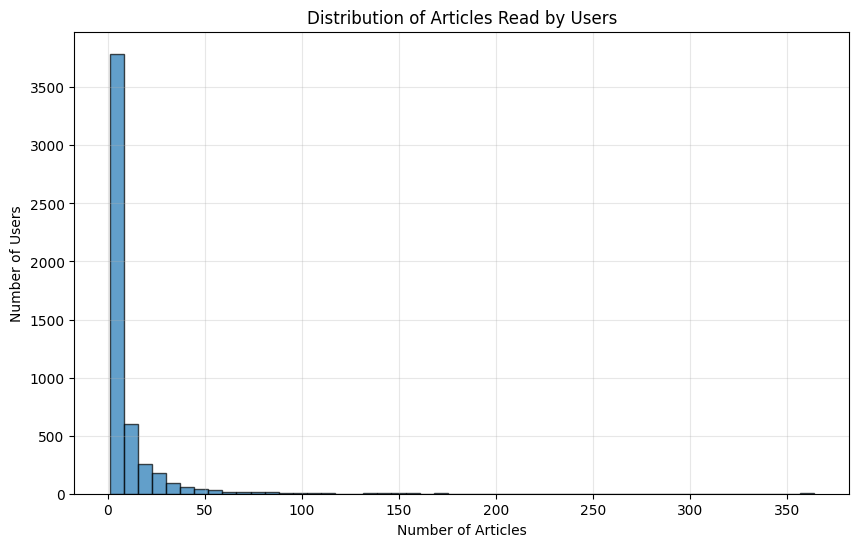

In [11]:
# Create a plot of the number of articles read by each user
plt.figure(figsize=(10, 6))
plt.hist(user_article_counts.values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Articles')
plt.ylabel('Number of Users')
plt.title('Distribution of Articles Read by Users')
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Display descriptive statistics for user article counts
print("Descriptive Statistics for Number of Articles per User:")
print(user_article_counts.describe())
print(f"\nMost active user read {user_article_counts.max()} articles")
print(f"Least active user read {user_article_counts.min()} articles")
print(f"Average number of articles per user: {user_article_counts.mean():.2f}")

Descriptive Statistics for Number of Articles per User:
count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

Most active user read 364 articles
Least active user read 1 articles
Average number of articles per user: 8.93


- There are 5149 users in total.
- On average, a user has interacted with approximately 9 articles, but the standard deviation is high (16.8) signifying a lot of variation.
- The minimum is 1, so every user has had at least 1 interaction.
- The median (50%) is 3, which means that half of users have interacted with 3 or fewer articles.
- The 75th percentile is 9, so 75% of users have interacted with 9 or fewer articles.
- The maximum is 364, signifying that some users are extremely active. 

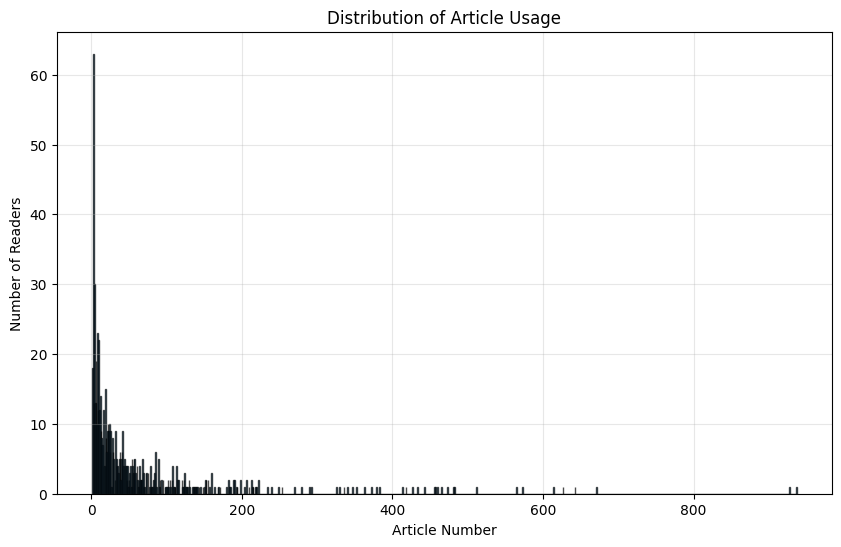

In [13]:
# Create a plot of the number of times each article was read
# Count how many users read each article
article_read_counts = df['article_id'].value_counts()
# article_read_counts = df.groupby('article_id')['email'].count()

plt.figure(figsize=(10, 6))
plt.hist(article_read_counts.values, bins=1000, edgecolor='black', alpha=0.7)
plt.xlabel('Article Number')
plt.ylabel('Number of Readers')
plt.title('Distribution of Article Usage')
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# Display descriptive statistics for article read counts
print("Descriptive Statistics for Article Read Counts:")
print(article_read_counts.describe())
print(f"\nMost popular article was read by {article_read_counts.max()} users")
print(f"Least popular article was read by {article_read_counts.min()} users")
print(f"Average number of users per article: {article_read_counts.mean():.2f}")
# print(f"Total number of unique articles: {len(article_read_counts)}")

Descriptive Statistics for Article Read Counts:
count    714.000000
mean      64.415966
std      109.175923
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: count, dtype: float64

Most popular article was read by 937 users
Least popular article was read by 1 users
Average number of users per article: 64.42


In [15]:
# Fill in the median and maximum number of user_article interactions below

# 50% of individuals interact with 3 number of articles or fewer.
median_val = user_article_counts.median()
# The maximum number of user-article interactions by any 1 user is 135.
max_views_by_user = user_article_counts.max()

print(f"Median number of articles per user: {median_val}")
print(f"Maximum number of articles read by any user: {max_views_by_user}")

Median number of articles per user: 3.0
Maximum number of articles read by any user: 364


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [16]:
# The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()
# The number of unique articles on the IBM platform
total_articles = df['article_id'].nunique()
unique_users = df['email'].nunique()  # The number of unique users
user_article_interactions = len(df)  # The number of user-article interactions

print(f"Number of unique articles with interactions: {unique_articles}")
print(f"Total number of unique articles: {total_articles}")
print(f"Number of unique users: {unique_users}")
print(f"Total user-article interactions: {user_article_interactions}")

Number of unique articles with interactions: 714
Total number of unique articles: 714
Number of unique users: 5149
Total user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [17]:
# The most viewed article in the dataset as a string with one value following the decimal
most_viewed_article_id = (article_read_counts.index[0])
# The most viewed article in the dataset was viewed how many times?
max_views = article_read_counts.iloc[0]

print(f"Most viewed article ID: {most_viewed_article_id}")
print(f"Number of times it was viewed: {max_views}")
print(
    f"Article title: {df[df['article_id'] == int(float(most_viewed_article_id))]['title'].iloc[0]}")

Most viewed article ID: 1429
Number of times it was viewed: 937
Article title: use deep learning for image classification


In [18]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]


df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [19]:
# If you stored all your results in the variable names above,
# you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [20]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 

    """
    # Group by title and count interactions, sort by count descending

    top_articles = (df.groupby('title')
                    .size()
                    .sort_values(ascending=False)
                    .head(n)
                    .index
                    .tolist())

    return top_articles  # Return the top article titles from df


def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_article_ids - (list) A list of the top 'n' article ids
    """

    # Get top article titles from the first function
    top_titles = get_top_articles(n, df)

    # Map titles back to article_id
    # drop_duplicates() ensures you don’t get multiple IDs for the same title
    top_article_ids = (df[df['title'].isin(top_titles)]
                       .drop_duplicates(subset=['title'])
                       .set_index('title')
                       .loc[top_titles]['article_id']
                       .tolist())

    return top_article_ids

In [21]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [22]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [23]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns

    OUTPUT:
    user_item - user item matrix 

    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    """
    # Drop duplicates so repeated interactions don't cause multiple counts
    df = df.drop_duplicates(subset=['user_id', 'article_id'])

    # Create the user-item matrix
    user_item = (df.groupby(['user_id', 'article_id'])
                 .size()
                 .unstack(fill_value=fill_value))

    # Convert counts to binary (1= interaction, 0 = no interaction)
    user_item = user_item.map(lambda x: 1 if x > 0 else 0)

    return user_item  # return the user_item matrix


user_item = create_user_item_matrix(df)

In [24]:
# Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[
    1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [25]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output

    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest similarity)
                    are listed first. If include_similarity=True, returns a list of lists
                    with [similar_user_id, similarity].
    """

    # index of target user
    target_idx = user_item.index.get_loc(user_id)

    # cosine similarity matrix (users x users)
    similarity_matrix = cosine_similarity(user_item.values)

    # similarity row for target user
    user_similarities = similarity_matrix[target_idx]

    # pair [user_id, similarity]
    sim_list = list(zip(user_item.index, user_similarities))

    # remove self
    sim_list = [x for x in sim_list if x[0] != user_id]

    # sort descending by similarity
    sim_list = sorted(sim_list, key=lambda x: x[1], reverse=True)

    if include_similarity:
        return sim_list  # list of [user_id, similarity]
    else:
        most_similar_users = [x[0] for x in sim_list]  # just user ids
        return most_similar_users

In [27]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(
    find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(
    find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(
    find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 46, 4201, 253, 824, 5034, 5041, 136, 2305, 395]
The 5 most similar users to user 3933 are: [1, 46, 4201, 253, 824]
The 5 most similar users to user 3933 are: [1, 46, 4201, 253, 824]
The 3 most similar users to user 46 are: [4201, 790, 5077]
The 3 most similar users to user 46 are: [4201, 790, 5077]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [28]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    # Drop duplicates so one id maps to a single title
    unique_articles = df[['article_id', 'title']].drop_duplicates()

    # Filter for the requested article_ids
    article_names = unique_articles[unique_articles['article_id'].isin(
        article_ids)]['title'].tolist()

    return article_names  # Return the article names associated with list of article ids


def get_ranked_article_unique_counts(article_ids=None, user_item=user_item):
    """
    INPUT:
    article_ids - (list or None) list of article IDs to restrict to, or None for all articles
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise 

    OUTPUT:
    article_counts - (list) a list of lists [article_id, unique_user_count],
                     sorted by the number of unique users in descending order
    """
    # Sum across users for each article (columns)
    article_user_counts = user_item.sum(axis=0)

    # If restricting to specific article_ids
    if article_ids is not None:
        article_user_counts = article_user_counts.loc[article_ids]

    # Sort by number of unique users (descending)
    ranked_article_unique_counts = article_user_counts.sort_values(
        ascending=False)

    # Convert to list of lists
    article_counts = [[int(aid), int(count)]
                      for aid, count in ranked_article_unique_counts.items()]

    return article_counts


def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)

    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Locate user's row
    user_row = user_item.loc[user_id]

    # Get article_ids where the user has interacted (value = 1)
    article_ids = user_row[user_row == 1].index.tolist()

    # Get article names from helper function
    article_names = get_article_names(article_ids, df)

    return article_ids, article_names  # return the ids and names


def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily

    """
    # Articles already seen by user
    seen_article_ids, _ = get_user_articles(user_id, user_item)

    # Get similar users in order
    similar_users = find_similar_users(user_id, user_item)

    recs = []  # list of recommended article ids

    # Loop through similar users and add unseen articles
    for sim_user in similar_users:
        sim_user_article_ids, _ = get_user_articles(sim_user, user_item)
        # Find articles not yet seen by the target user but seen by similar user
        new_recs = [
            art for art in sim_user_article_ids if art not in seen_article_ids and art not in recs]
        recs.extend(new_recs)
        if len(recs) >= m:
            recs = recs[:m]  # Trim to m recommendations
            break

    return recs  # return your recommendations for this user_id

In [29]:
# Check Results
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10))

['leverage python, scikit, and text classification for behavioral profiling',
 'challenges in deep learning',
 'awesome deep learning papers',
 'this week in data science (april 18, 2017)',
 'improving the roi of big data and analytics through leveraging new sources of data',
 'this week in data science (may 2, 2017)',
 'using apply, sapply, lapply in r',
 'how can data scientists collaborate to build better business',
 'top 20 r machine learning and data science packages',
 'do i need to learn r?']

In [30]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [31]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model',
                                                                            'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery',
                                                        'use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures',
                                             'self-service data preparation with ibm data refinery', 'use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(
    [1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model',
                                            'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [
    1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [32]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise


    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user

    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe, i.e. Descending order

    """
    import pandas as pd

    # Get similar users including similarity
    sim_list = find_similar_users(user_id, user_item, include_similarity=True)

    # Convert to dataframe
    neighbors_df = pd.DataFrame(
        sim_list, columns=['neighbor_id', 'similarity'])

    # Calculate number of interactions for each neighbor
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(
        lambda x: user_item.loc[x].sum())

    # Sort by similarity and then number of interactions (both descending)
    neighbors_df = neighbors_df.sort_values(
        by=['similarity', 'num_interactions'], ascending=False)

    # Reset index for clean output
    neighbors_df = neighbors_df.reset_index(drop=True)

    return neighbors_df  # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 

    """
    # Articles already seen by user
    seen_article_ids, _ = get_user_articles(user_id, user_item)

    # Neighbors sorted by similarity and total interactions
    neighbors_df = get_top_sorted_users(user_id, user_item)

    # Article popularity ranking (most interactions first)
    article_popularity = get_ranked_article_unique_counts(None, user_item)
    article_popularity_dict = {aid: count for aid, count in article_popularity}

    recs = []
    for _, row in neighbors_df.iterrows():
        neighbor_id = row['neighbor_id']
        # Find articles the neighbor has interacted with that the user hasn't seen
        neighbor_article_ids, _ = get_user_articles(neighbor_id, user_item)
        unseen_articles = [
            aid for aid in neighbor_article_ids if aid not in seen_article_ids]
        # Rank unseen articles by popularity
        unseen_articles.sort(
            key=lambda x: article_popularity_dict.get(x, 0), reverse=True)
        # Add to recommendations
        recs.extend(unseen_articles)
        if len(recs) >= m:
            break

    # return your recommendations for this user_id
    return recs, get_article_names(recs)

In [33]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1185, 1162, 1165, 1293, 1185, 1165, 1293, 254, 1271, 1328, 1410, 40, 1402]

The top 10 recommendations for user 20 are the following article names:
['classify tumors with machine learning', 'analyze energy consumption in buildings', 'uci: sms spam collection', 'income (2015): united states demographic measures', 'analyze precipitation data', 'finding optimal locations of new store using decision optimization', 'uci: adult - predict income', 'customer demographics and sales', 'ensemble learning to improve machine learning results', 'apple, ibm add machine learning to partnership with watson-core ml coupling']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [34]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013                35
   neighbor_id  similarity  num_interactions
0         5083    0.730297                 5
1         1552    0.577350                 2
2         1890    0.577350                 2
3         1372    0.471405                 3
4         2941    0.433013                 8
5         3586    0.408248                 4
6          331    0.408248                 1
7          348    0.408248                 1
8          378    0.408248                 1
9          496    0.408248                 1
   neighbor_id  similarity  num_interactions
0         3870    0.986667                75
1          203    0.388909                96
2         4459    0.388909                96
3         3782    0.387585               135
4           40    0.384308                52
5         4932    0.384308                52
6           23    0.377647               135
7          242    0.375823                59
8         

In [35]:
# Tests with a dictionary of results
# Most similar user to user 1
user1_most_sim = get_top_sorted_users(
    1, user_item=user_item).iloc[0, 0]  # neighbor_id of first row

# 6th most similar user to user 2
user2_6th_sim = get_top_sorted_users(
    2, user_item=user_item).iloc[5, 0]  # 6th row (zero-indexed)

# 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(
    131, user_item=user_item).iloc[9, 0]  # 10th row (zero-indexed)

In [36]:
# Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

<b>Answer:</b>

For a new user (with no prior interactions), one could use the function that ranks articles by overall popularity, the `get_top_articles()` function. This is a "popularity-based" recommendation and is a common baseline for new users (known as the cold start problem).

However, a better way might be to use content-based recommendations, where one could suggest articles similar to those the user has viewed (if one has any info about their interests or profile), or to use demographic or contextual information if available. As the user interacts more, one can switch to collaborative filtering or personalized models for improved recommendations.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [37]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to
# Use the rank-based function for new users
new_user_recs = get_top_article_ids(10)

print("Top 10 recommendations for a new user:")
print("Article IDs:", new_user_recs)
print("\nArticle Titles:")
for i, title in enumerate(get_article_names(new_user_recs), 1):
    print(f"{i}. {title}")

Top 10 recommendations for a new user:
Article IDs: [1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]

Article Titles:
1. healthcare python streaming application demo
2. use deep learning for image classification
3. apache spark lab, part 1: basic concepts
4. predicting churn with the spss random tree algorithm
5. analyze energy consumption in buildings
6. visualize car data with brunel
7. use xgboost, scikit-learn & ibm watson machine learning apis
8. gosales transactions for logistic regression model
9. insights from new york car accident reports
10. finding optimal locations of new store using decision optimization


In [38]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431,
                              1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [39]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [40]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [41]:
# unique articles
df_unique_articles = df[['article_id', 'title']
                        ].drop_duplicates().reset_index(drop=True)
print(df_unique_articles.head())

   article_id                                              title
0        1430  using pixiedust for fast, flexible, and easier...
1        1314       healthcare python streaming application demo
2        1429         use deep learning for image classification
3        1338          ml optimization using cognitive assistant
4        1276          deploy your python model as a restful api


In [42]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df_unique_articles['title'])

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


Text(0.5, 0, 'Number of clusters')

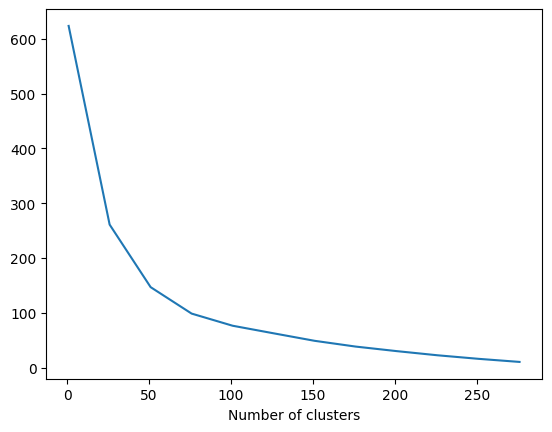

In [43]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')

There appears to be an elbow about 50, so we'll use 50 clusters.

In [44]:
n_clusters = 50  # Number of clusters
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state,
    # Your code here, same as parameters above
).fit(X_lsa)

In [45]:
# Get assigned labels
labels = kmeans.labels_

# Attach cluster labels to the original DataFrame
df_unique_articles['cluster'] = labels

In [46]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df
article_cluster_map = {
    article_id: cluster
    for article_id, cluster in zip(df_unique_articles['article_id'], df_unique_articles['cluster'])
}  # Map article_id to cluster label
df['title_cluster'] = df['article_id'].map(
    article_cluster_map)  # apply map to create title clusters

In [47]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 12],
       [ 1, 32],
       [ 2,  7],
       [ 3, 72],
       [ 4, 37],
       [ 5, 13],
       [ 6, 17],
       [ 7, 20],
       [ 8, 20],
       [ 9, 28],
       [10,  9],
       [11, 23],
       [12, 20],
       [13, 12],
       [14, 24],
       [15, 13],
       [16,  7],
       [17,  7],
       [18, 16],
       [19,  7],
       [20, 11],
       [21,  5],
       [22, 10],
       [23, 12],
       [24, 11],
       [25, 15],
       [26, 42],
       [27, 14],
       [28,  8],
       [29,  8],
       [30,  5],
       [31, 10],
       [32,  8],
       [33,  6],
       [34,  5],
       [35,  6],
       [36,  9],
       [37, 12],
       [38, 12],
       [39, 10],
       [40, 10],
       [41,  9],
       [42, 12],
       [43,  6],
       [44,  7],
       [45, 12],
       [46, 11],
       [47, 22],
       [48,  3],
       [49,  7]])

In [48]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 

    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster

    Description:
    Returns a list of the article ids that are in the same title cluster
    """
    # Find which title_cluster article_id belongs to
    title_cluster = df.loc[df['article_id'] ==
                           article_id, 'title_cluster'].iloc[0]
    articles_in_cluster = df.loc[df['title_cluster']
                                 == title_cluster, 'article_id'].tolist()

    # remove the input article_id from the list
    articles_in_cluster = [a for a in articles_in_cluster if a != article_id]
    return articles_in_cluster

In [49]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids

    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    # Get articles in the same cluster
    articles_in_cluster = get_similar_articles(article_id, df)

    # If no similar articles found, return empty lists
    if not articles_in_cluster:
        return [], []

    # Rank the similar articles by popularity (number of unique users who interacted with them)
    ranked_articles = get_ranked_article_unique_counts(articles_in_cluster)

    # Extract just the article IDs and take the top n
    n_ranked_similar_articles = [article[0] for article in ranked_articles[:n]]

    # Get the corresponding article names
    n_ranked_article_names = get_article_names(n_ranked_similar_articles, df)

    return n_ranked_similar_articles, n_ranked_article_names

In [50]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025]
['data tidying in data science experience']


In [51]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))
           ) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

### <u>Answer: Content-Based Recommendation System Summary</u>

#### How the Content-Based Recommender Works

The system follows a straightforward pipeline:

1. **TF-IDF on Titles**  
   We apply TF-IDF vectorization to article titles to convert them into numerical features. This helps us pick up which words are relatively important in each title compared to the rest of the dataset.

2. **Reducing Dimensions with SVD**  
   Since TF-IDF gives us high-dimensional vectors, we use Truncated SVD to compress this into 50 components. This speeds things up and reduces noise while keeping most of the underlying structure.

3. **Clustering with K-Means**  
   We cluster the articles using K-Means (with k=50) on the reduced feature set. Articles that land in the same cluster are treated as being topically similar.

4. **Generating Recommendations**  
   The `make_content_recs()` function works as follows:  
   - Identify the cluster of the given article  
   - Retrieve all other articles in that same cluster  
   - Rank them by the number of unique users who interacted with each one  
   - Return the top-ranked results

#### Ideas for Improvement

1. **Stronger Text Features**  
   Titles are often too short. Adding article descriptions, abstracts, or even full text would provide more signal. We could also improve text preprocessing (e.g., lemmatization, n-grams) or swap out TF-IDF for embeddings like Word2Vec, GloVe, or BERT.

2. **Better Clustering**  
   K-Means works, but we might get more interpretable groupings using hierarchical clustering or topic models like LDA or BERTopic. There’s also room to explore dynamic clustering that adapts based on what users engage with.

3. **Move Toward a Hybrid Model**  
   We can combine this content approach with collaborative filtering. For example, use content similarity to filter candidates and rank them using collaborative scores, or blend the two directly in a weighted model.

4. **User-Level Personalization**  
   Rather than just clustering articles, we can try learning what kinds of content a specific user prefers and tailor similarity measures accordingly. That includes accounting for recency, topic diversity, or even content complexity.

#### Useful Text Data (If Available)

1. **Article Metadata**  
   Things like categories, tags, author info, publication date, and article length would help us understand the nature of each article beyond its title.

2. **Full Content**  
   Access to full text, summaries, or key bullet points would give much richer signals. Any embedded code or mentioned technologies could also be extracted and indexed.

3. **User Contributions**  
   Comments, ratings, user-added tags, and social sharing behavior would all offer useful context for gauging article relevance or quality.

4. **Contextual Signals**  
   Reading level, prerequisite knowledge, and domain classification (e.g., data science vs. web dev) would help match articles to users more appropriately.

These additions would make it easier to build recommendations that go beyond surface similarity and reflect deeper content structure and user preferences.


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [52]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [53]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns),
                   n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

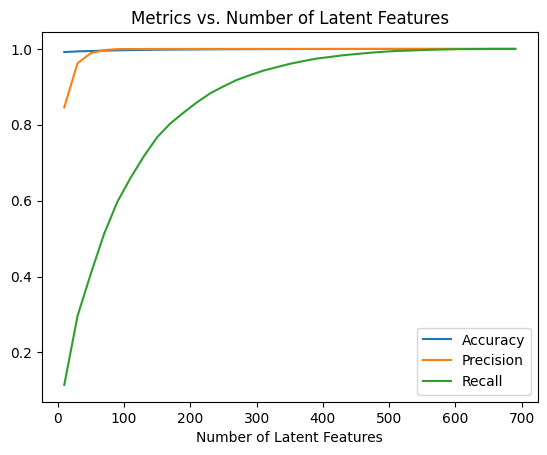

In [54]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]

    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)

    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(
        user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])


plt.plot(num_latent_feats, metric_scores, label=[
         'Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

## <u> Answer: Choosing the Optimal Number of Latent Features</u>

Looking at the plot of accuracy, precision, and recall against the number of latent features, a range of **150–200 latent features** seems most appropriate.  

### Trade-offs to Consider

**1. Performance Plateau**  
- Metrics improve rapidly when moving from 10 up to about 100–150 features  
- After 150–200 features the gains become marginal  
- This shows a clear pattern of diminishing returns  

**2. Risk of Overfitting**  
- Using very high numbers of features (400–700) can slightly improve reconstruction accuracy, but this often signals overfitting  
- The purpose is not exact reconstruction of the user–item matrix, but uncovering latent patterns that transfer well to new recommendations  

**3. Efficiency**  
- More features mean more cost in training and prediction  
- Staying around 150–200 provides a good balance between expressiveness and runtime  

**4. Generalization and Interpretability**  
- A moderate number of features is more likely to reflect real user preferences and item traits  
- Too many features risk fitting noise instead of meaningful structure  
- The 150–200 range allows complex patterns to be learned without the model becoming overly specific to the training data  

### Why Reconstruction Accuracy Is Not the Goal

A perfect fit to the 1s and 0s of the matrix does not guarantee useful recommendations. What matters is:  

- Capturing user preferences and item similarities in a meaningful way  
- Generalizing to new, unseen user–item interactions  
- Staying robust in sparse settings  

### Practical Recommendation

- **200 latent features** can be treated as an upper bound that still balances complexity and performance  
- This number provides enough flexibility to capture diverse tastes and item characteristics without excessive computation or overfitting  

In summary, **150–200 latent features** is the optimal range, with **200** being a safe and effective choice.


`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [55]:
def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output

    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster

    Description:
    Returns a list of the article ids similar using SVD factorization
    """
    # Find the index of the article_id
    article_idx = user_item.columns.get_loc(article_id)

    # Find the cosine similarity of all articles
    # Hint: vt should be transposed before passing to cosine_similarity to get a 714 x 714 matrix
    cos_sim = cosine_similarity(vt.T)

    # Get similarities only for the cos_sim of the article_idx
    article_similarities = cos_sim[article_idx]

    # Sort and return the articles, don't include the own article
    # Create pairs of (article_id, similarity) and sort by similarity descending
    article_sim_pairs = list(zip(user_item.columns, article_similarities))
    # Remove the input article itself
    article_sim_pairs = [
        pair for pair in article_sim_pairs if pair[0] != article_id]
    # Sort by similarity (descending)
    article_sim_pairs.sort(key=lambda x: x[1], reverse=True)

    if include_similarity:
        # return a list of lists with [[similar_article_id, similarity], ...]
        return [[int(aid), float(sim)] for aid, sim in article_sim_pairs]

    most_similar_items = [int(aid) for aid, sim in article_sim_pairs]
    return most_similar_items

In [56]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [57]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [58]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [ ]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

In [59]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58,
                             132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

## <u>Analysis of Recommendation Results and Method Comparison</u>

### SVD-Based Matrix Factorization Results

The SVD-based recommendations for article ID 4 indicate potential for identifying articles with similar latent feature patterns. These results are driven by user-item interaction structures rather than explicit content similarity, which allows the model to uncover relationships that may not be obvious from article titles alone.

### Evaluating Recommendation Quality

To assess whether these recommendations improve on existing methods, we can rely on three main approaches:

#### 1. **Offline Evaluation Metrics**
- **Precision@K and Recall@K**: Assess how many recommended articles align with actual user interactions  
- **Mean Average Precision (MAP)**: Capture ranking quality across users  
- **Coverage**: Ensure recommendations are not concentrated on only the most popular articles  
- **Diversity**: Check that recommended articles differ from one another  
- **Novelty**: Identify whether users are exposed to articles they might not otherwise encounter  

#### 2. **A/B Testing**
- Split users into groups and compare recommendation methods  
- Track click-through rates, reading time, and reported satisfaction  
- Measure long-term outcomes such as engagement and retention  

#### 3. **Cross-Validation**
- Use temporal splits, training on older data and testing on newer interactions  
- Apply leave-one-out validation for users with sparse histories  

### Comparison of Recommendation Methods
This provides a broad comparison of the techniques employed but in no way is meant to be exhaustive.

| Method | Strengths | Weaknesses | Best Use Case |
|--------|-----------|------------|---------------|
| **Rank-Based (Section 2)** | • Simple and efficient<br>• Always produces output<br>• Good starting baseline<br>• No cold start issues | • No personalization<br>• Popularity bias<br>• Limited discovery potential | **Completely new users with no history** |
| **User-User Collaborative (Section 3)** | • Personalized<br>• Captures user preferences<br>• Supports discovery of new content | • Struggles with cold start<br>• Sensitive to sparse data<br>• Can be computationally heavy<br>• Still subject to popularity bias | **Users with moderate to rich interaction history** |
| **Content-Based (Section 4)** | • No cold start for items<br>• Transparent recommendations<br>• Works with limited user data | • Constrained by available content features<br>• Risk of over-specialization<br>• Requires strong content representation | **New users with some early interactions, or items with detailed metadata** |
| **Matrix Factorization (Section 5)** | • Effective with sparse data<br>• Captures hidden structure<br>• Scalable<br>• Strong overall performance | • Cold start limitations<br>• Harder to interpret<br>• Requires careful parameter tuning | **Established users with interaction history, large-scale systems** |

### Strategic Implementation by User Type

#### **New Users (No History)**
1. **Primary**: Rank-based recommendations of popular content  
2. **Secondary**: Content-based if initial preferences are provided  
3. **Strategy**: Focus on quick onboarding through popular articles, then introduce personalization  

#### **Recently New Users (1–5 Interactions)**
1. **Primary**: Content-based recommendations from early interactions  
2. **Secondary**: Rank-based to maintain diversity  
3. **Hybrid**: Blend content similarity with popularity scores  
4. **Strategy**: Begin building a user profile while keeping engagement high  

#### **Active Users (6+ Interactions)**
1. **Primary**: Matrix factorization for deeper pattern recognition  
2. **Secondary**: User-user collaborative filtering to capture social discovery effects  
3. **Tertiary**: Content-based to improve diversity and transparency  
4. **Strategy**: Deliver highly personalized recommendations while mixing in popular content for novelty  

### Hybrid Recommendation Strategy

The most practical approach is a hybrid model that adapts to user history:

```python
def hybrid_recommendations(user_id, user_interaction_count):
    if user_interaction_count == 0:
        # New user
        return get_top_article_ids(10)
    elif user_interaction_count <= 5:
        # Recently new user
        content_recs = get_content_recommendations_for_user(user_id, 7)
        popular_recs = get_top_article_ids(3)
        return combine_recommendations(content_recs, popular_recs)
    else:
        # Active user
        svd_recs = get_svd_user_recommendations(user_id, 6)
        collab_recs = user_user_recs(user_id, 3)
        content_recs = get_content_recommendations_for_user(user_id, 1)
        return combine_recommendations(svd_recs, collab_recs, content_recs)


In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', '--to',
     'html', 'Recommendations_with_IBM.ipynb'])